In [1]:
# link: https://github.com/liyaguang/DCRNN
import numpy as np
import pandas as pd
import json

In [2]:
import os
import pandas as pd
import geopandas as gpd
import tqdm
import datetime
import numpy as np
import matplotlib.pyplot as plt
from cartoframes.viz import *
from tqdm import notebook

In [3]:
def ensure_dir(dir_path):
    """Make sure the directory exists, if it does not exist, create it.

    Args:
        dir_path (str): directory path
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [4]:
import os
import datetime
# link: https://github.com/liyaguang/DCRNN
import numpy as np
import pandas as pd
import json

dataset_name = 'SVOL'
outputdir = f'../Bigscity-LibCity/raw_data/{dataset_name}'
ensure_dir(outputdir)
dataname = outputdir+f'/{dataset_name}'

P_SEQ = 6
Q_SEQ = 6

In [5]:
sorted(os.listdir('../dataprocess/seouldata'))

['floating-population-2017-a20.csv',
 'floating-population-2017-a30.csv',
 'floating-population-2017-a40.csv',
 'floating-population-2017-a50.csv',
 'floating-population-2017-a60.csv',
 'floating-population-2017-total.csv',
 'floating-population-2018-a20.csv',
 'floating-population-2018-a30.csv',
 'floating-population-2018-a40.csv',
 'floating-population-2018-a50.csv',
 'floating-population-2018-a60.csv',
 'floating-population-2018-total.csv',
 'local_people_area.geojson',
 'seoul_link_network.geojson',
 'speed-2017.csv',
 'speed-2018.csv',
 'subway-data-off-2017.csv',
 'subway-data-off-2018.csv',
 'subway-data-on-2017.csv',
 'subway-data-on-2018.csv',
 'volume_data_2017.csv',
 'volume_data_2018.csv',
 'volume_data_edit_2017.csv',
 'volume_data_edit_2018.csv',
 'vsensor_locations.geojson']

In [6]:
vol_df = pd.concat([
    pd.read_csv('../dataprocess/seouldata/volume_data_2017.csv', index_col=0),
    pd.read_csv('../dataprocess/seouldata/volume_data_2018.csv', index_col=0)
])

vol_df.index = pd.to_datetime(vol_df.index)
vol_df = vol_df.fillna(0)
vol_df = vol_df.iloc[:, (np.sum(np.isnan(vol_df), 0) + (np.sum(vol_df==0)) < 1000).tolist()]

In [18]:
assert len(vol_df) == 24*(365+365)

In [7]:
data = vol_df.values
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data[i, j] == 0:
            val1 = 0
            val2 = 0
            loop = 0
            while val1 == 0:
                loop += 24*7
                if i - loop < 0:
                    break
                val1 = data[i - loop, j]
            loop = 0
            while val2 == 0:
                loop += 24*7
                if i + loop >= data.shape[0]:
                    val2 = val1
                    break
                val2 = data[i + loop, j]
            if val1 == 0:
                val1 = val2
            data[i, j] = (val1 + val2) / 2

In [8]:
data.shape

(17520, 73)

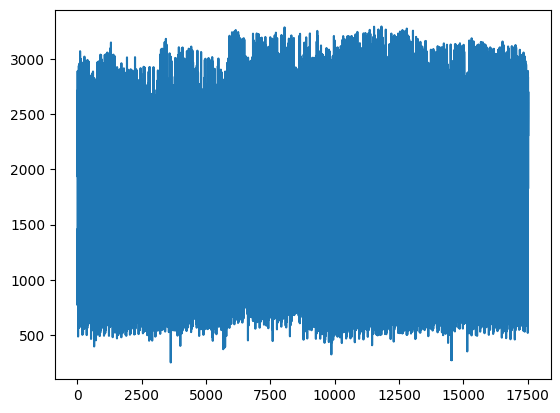

In [9]:
plt.plot(data[:, 64])

In [10]:
data_df = pd.DataFrame(data, columns=vol_df.columns, index=vol_df.index)

In [11]:
network_gdf = gpd.read_file('../dataprocess/seouldata/vsensor_locations.geojson')

In [12]:
##################
idset = set()
geo = []
for _, sensor in network_gdf.iterrows():
    for io in ['I', 'O']:
        id = f"{sensor['spot_num']}-{io}"
        lat = sensor.geometry.y
        lon = sensor.geometry.x
        if id not in idset:
            idset.add(id)
            geo.append([id, 'Point', '['+str(lon)+', '+str(lat)+']'])
        
geo = pd.DataFrame(geo, columns=['geo_id', 'type', 'coordinates'])
geo = geo[geo['geo_id'].isin(data_df.columns)]
geo.to_csv(dataname+'.geo', index=False)

In [13]:
import shapely
item_list = []
for _, item in geo.iterrows():
    itemdict = dict(item)
    itemdict['geometry'] = shapely.Point([float(v) for v in itemdict['coordinates'][1:-1].split(',')])    
    item_list.append(itemdict)
again_gdf = gpd.GeoDataFrame(item_list)
again_gdf.crs = 'epsg:4326'
again_5181_gdf = again_gdf.to_crs('epsg:5181')

In [14]:
#############################
rel = []
reldict = dict()

for _, geo1 in again_5181_gdf.iterrows():
    for _, geo2 in again_5181_gdf.iterrows():
        sid, eid, cost = geo1.geo_id, geo2.geo_id, geo1.geometry.distance(geo2.geometry)
        if sid not in idset or eid not in idset:
            continue
        if cost == 0:
            continue
        if (sid, eid) not in reldict:
            reldict[(sid, eid)] = len(reldict)
            rel.append([len(reldict) - 1, 'geo', sid, eid, cost])
            
rel = pd.DataFrame(rel, columns=['rel_id', 'type', 'origin_id', 'destination_id', 'cost'])
rel.to_csv(dataname+'.rel', index=False)

In [15]:
data_df.index = pd.to_datetime(data_df.index)
data_df.to_hdf(dataname + '_ALL.hdf', key='df')

In [16]:
df = pd.read_hdf(dataname + '_ALL.hdf', key='df')
seniorlist = list(df.columns)
timeslot = pd.to_datetime(df.index)
dataset = pd.DataFrame(df.values, columns=seniorlist)

# dyna = []
dyna_id = 0
dyna_file = open(dataname+'.dyna', 'w')
dyna_file.write('dyna_id' + ',' + 'type' + ',' + 'time' + ',' + 'entity_id' + ',' + 'traffic_speed' + '\n')
for j in range(len(seniorlist)):
    entity_id = seniorlist[j]
    for i in range(timeslot.shape[0]):
#         time = str(timeslot[i])[:-10]+'Z'
        time = str(timeslot[i])+'Z'
        # dyna.append([dyna_id, 'state', time, entity_id, dataset[seniorlist[j]][i]])
        dyna_file.write(str(dyna_id) + ',' + 'state' + ',' + str(time)
                        + ',' + str(entity_id) + ',' + str(dataset[seniorlist[j]][i]) + '\n')
        dyna_id = dyna_id + 1
        if dyna_id % 10000 == 0:
            print(str(dyna_id) + '/' + str(timeslot.shape[0]*len(seniorlist)))
dyna_file.close()
# dyna = pd.DataFrame(dyna, columns=['dyna_id', 'type', 'time', 'entity_id', 'traffic_speed'])
# dyna.to_csv(dataname+'.dyna', index=False)


config = dict()
config['geo'] = dict()
config['geo']['including_types'] = ['Point']
config['geo']['Point'] = {}
config['rel'] = dict()
config['rel']['including_types'] = ['geo']
config['rel']['geo'] = {'cost': 'num'}
config['dyna'] = dict()
config['dyna']['including_types'] = ['state']
config['dyna']['state'] = {'entity_id': 'geo_id', 'traffic_speed': 'num'}
config['info'] = dict()
config['info']['data_col'] = 'traffic_speed'
config['info']['weight_col'] = 'cost'
config['info']['data_files'] = [dataset_name]
config['info']['geo_file'] = dataset_name
config['info']['rel_file'] = dataset_name
config['info']['output_dim'] = 1
config['info']['time_intervals'] = 300
config['info']['init_weight_inf_or_zero'] = 'inf'
config['info']['set_weight_link_or_dist'] = 'dist'
config['info']['calculate_weight_adj'] = True
config['info']['weight_adj_epsilon'] = 0.1
json.dump(config, open(outputdir+'/config.json', 'w', encoding='utf-8'), ensure_ascii=False)

10000/1278960
20000/1278960
30000/1278960
40000/1278960
50000/1278960
60000/1278960
70000/1278960
80000/1278960
90000/1278960
100000/1278960
110000/1278960
120000/1278960
130000/1278960
140000/1278960
150000/1278960
160000/1278960
170000/1278960
180000/1278960
190000/1278960
200000/1278960
210000/1278960
220000/1278960
230000/1278960
240000/1278960
250000/1278960
260000/1278960
270000/1278960
280000/1278960
290000/1278960
300000/1278960
310000/1278960
320000/1278960
330000/1278960
340000/1278960
350000/1278960
360000/1278960
370000/1278960
380000/1278960
390000/1278960
400000/1278960
410000/1278960
420000/1278960
430000/1278960
440000/1278960
450000/1278960
460000/1278960
470000/1278960
480000/1278960
490000/1278960
500000/1278960
510000/1278960
520000/1278960
530000/1278960
540000/1278960
550000/1278960
560000/1278960
570000/1278960
580000/1278960
590000/1278960
600000/1278960
610000/1278960
620000/1278960
630000/1278960
640000/1278960
650000/1278960
660000/1278960
670000/1278960
6800